<a href="https://colab.research.google.com/github/Arcus0800/repo1/blob/main/CleanLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing Needed packages

In [56]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

Setting needed inputs and target

input = np.array([[4,6],
                  [5,8],
                  [5,5],
                  [6,9],
                  [8,15],
                  [9,13],
                  [10,15],
                  [12,16],
                  [12,19],
                  [14,22]], dtype='float32')

target = np.array([[24, 16, 36],
                        [40, 25, 64],
                        [25, 25, 25],
                        [54, 36, 81],
                        [120, 64, 225],
                        [117, 81, 169],
                        [150, 100, 225],
                        [192, 144, 256],
                        [228, 144, 361],
                        [308, 196, 484]], dtype='float32')

In [83]:
input = np.array([[3,2],
                  [7,6],
                  [16,5],
                  [14,2],
                  [12,7],
                  [7,4],
                  [4,4],
                  [19,2],
                  [4,8],
                  [8,4]], dtype='float32')

target = np.array([[76],
                   [88],
                   [96],
                   [90],
                   [98],
                   [80],
                   [86],
                   [89],
                   [68],
                   [75]], dtype='float32')

testinput = np.array([[8,1],
                      [14,2],
                      [7,4],
                      [3,3]], dtype='float32')
testtarget = np.array([[72],
                       [90],
                      [80],
                      [76]], dtype='float32')

input = torch.from_numpy(input)
target = torch.from_numpy(target)
testinput = torch.from_numpy(testinput)
testtarget = torch.from_numpy(testtarget)

print(input)
print(target)

tensor([[ 3.,  2.],
        [ 7.,  6.],
        [16.,  5.],
        [14.,  2.],
        [12.,  7.],
        [ 7.,  4.],
        [ 4.,  4.],
        [19.,  2.],
        [ 4.,  8.],
        [ 8.,  4.]])
tensor([[76.],
        [88.],
        [96.],
        [90.],
        [98.],
        [80.],
        [86.],
        [89.],
        [68.],
        [75.]])


Defining kernel function

In [58]:
def rbf_kernel(x1, x2, gamma=1.0):
    sq_dist = torch.cdist(x1, x2) ** 2
    return torch.exp(-gamma * sq_dist)

Defining mode

In [59]:
class RBFModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(RBFModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

Training model

In [60]:
def train_with_kernel(num_epochs, model, lossFn, opt, dl, kernel_fn):
    train_loss = []
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        for i, j in dl:
            opt.zero_grad()
            pred = model(i)
            loss = lossFn(pred, j)
            kernel_matrix = kernel_fn(pred, j)
            loss += torch.mean(kernel_matrix)  # Incorporate the kernel into the loss
            loss.backward()
            opt.step()
            epoch_loss += loss.item()

        avg_loss = epoch_loss / len(dl)
        train_loss.append(avg_loss)
        if (epoch + 1) % 1000 == 0:
            print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch + 1, num_epochs, avg_loss))

    plt.figure(figsize=(10, 5))
    plt.plot(train_loss, label='Train Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Losses')
    plt.legend()
    plt.show()


Start Training

Epoch [1000/5000], Loss: 0.2163
Epoch [2000/5000], Loss: 0.2011
Epoch [3000/5000], Loss: 0.2148
Epoch [4000/5000], Loss: 0.2430
Epoch [5000/5000], Loss: 0.2284


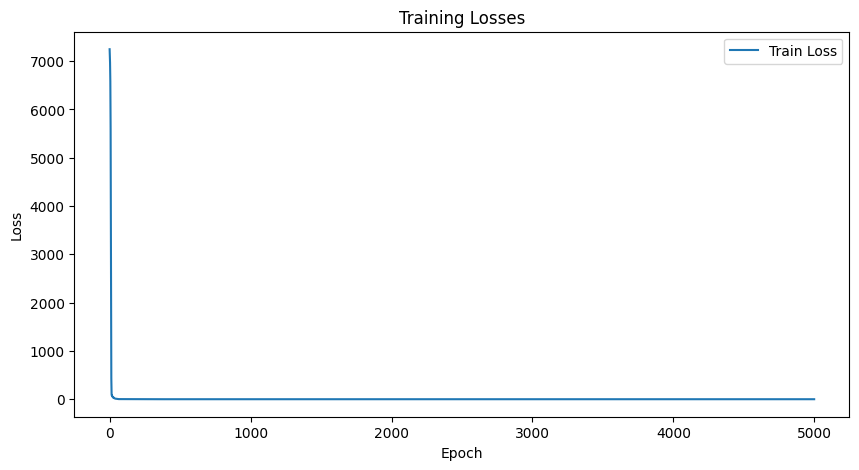

In [68]:
# Assuming input and target tensors are defined elsewhere
input_transformed =  rbf_kernel(input, input)
ds = TensorDataset(input_transformed, target)
batch_size = 5
dl = DataLoader(ds, batch_size, shuffle=True)

# Define your model
model = RBFModel(input_dim=input_transformed.shape[1], hidden_dim=10, output_dim=1)

lossFn = F.mse_loss
opt = torch.optim.SGD(model.parameters(), lr=0.001)

# Train the model with the RBF kernel function
num_epochs = 5000
train_with_kernel(num_epochs, model, lossFn, opt, dl, rbf_kernel)

Eval

tensor([[77.1858],
        [90.0352],
        [80.0045],
        [77.9126]])
tensor([[72.],
        [90.],
        [80.],
        [76.]])
Mean Squared Error on Test Data: 7.638030052185059


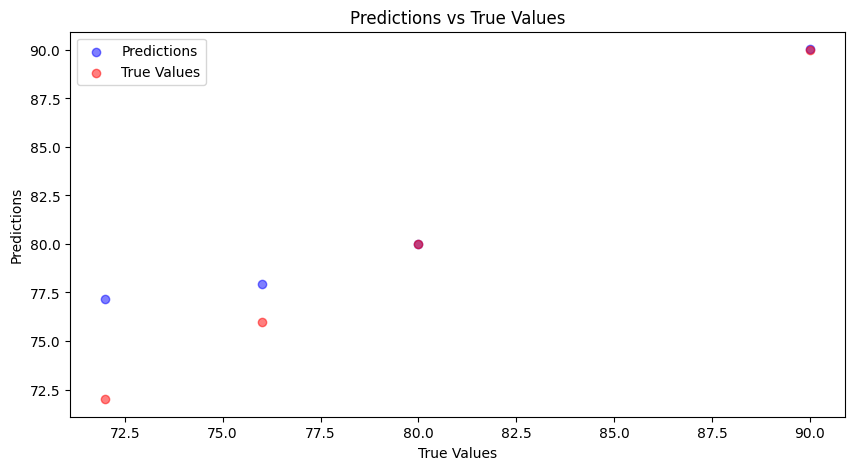

In [84]:
test_input_transformed = rbf_kernel(testinput, input)

# Convert to a DataLoader for batch processing
test_ds = TensorDataset(test_input_transformed, testtarget)
test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Load the Trained Model
model.eval()  # Set the model to evaluation mode

# Make Predictions
all_predictions = []
all_targets = []

with torch.no_grad():  # Disable gradient computation
    for inputs, targets in test_dl:
        predictions = model(inputs)
        all_predictions.append(predictions)
        all_targets.append(targets)

# Concatenate all predictions and targets
all_predictions = torch.cat(all_predictions, dim=0)
all_targets = torch.cat(all_targets, dim=0)
print(all_predictions)
print(all_targets)
# Evaluate Predictions (calculate MSE)
mse = F.mse_loss(all_predictions, all_targets)
print(f'Mean Squared Error on Test Data: {mse.item()}')

# Plot predictions vs true values
plt.figure(figsize=(10, 5))
plt.scatter(all_targets.numpy(), all_predictions.numpy(), alpha=0.5, color='blue', label='Predictions')
plt.scatter(all_targets.numpy(), all_targets.numpy(), alpha=0.5, color='red', label='True Values')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.legend()
plt.show()